In [19]:
from __future__ import print_function
from time import time

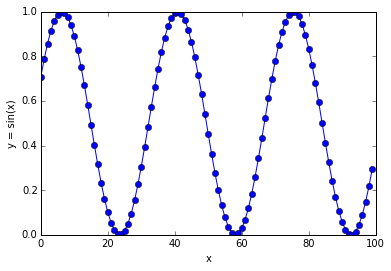

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1, 10, 100)
y = np.sin(x) ** 2

plt.plot(y, 'o-')
plt.xlabel('x')
plt.ylabel('y = sin(x)')

In [21]:
import logging
from sklearn.datasets import fetch_lfw_people

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data
n_samples, n_features = X.shape

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [22]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print("height: %d pixels" % h)
print("width: %d pixels" % w)

height: 50 pixels
width: 37 pixels


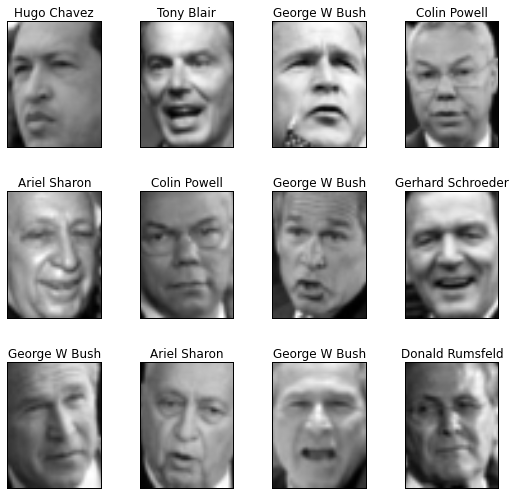

In [23]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

        
plot_gallery(X, target_names[y], h, w)

Split dataset into a training and testing set

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

### Compute a PCA (eigenfaces) on the face dataset

Unsupervised feature extraction / dimensionality reduction

Extracting the top 150 eigenfaces from 966 faces
done in 0.379s


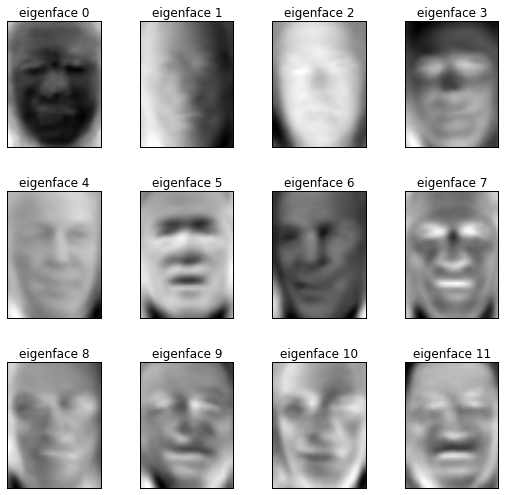

In [27]:
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [28]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.046s


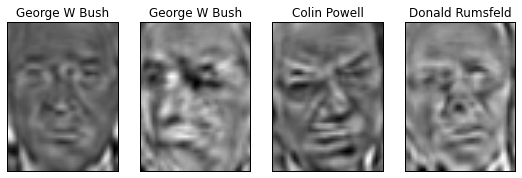

In [29]:
X_train_reconstructed = np.dot(X_train_pca, pca.components_)
plot_gallery(X_train_reconstructed, target_names[y_train], h, w, n_row=1)

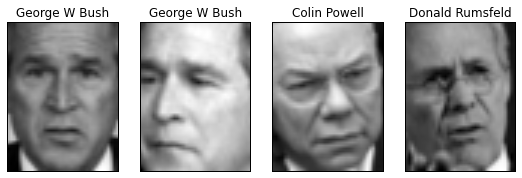

In [30]:
plot_gallery(X_train, target_names[y_train], h, w, n_row=1)

### Training on classification model on the new representation

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100],
              'gamma': [0.0001, 0.001, 0.01, 0.1]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=2)
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 4.402s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Qualitative evaluation of the model quality on the test set

Predicting people's names on the test set
done in 0.059s


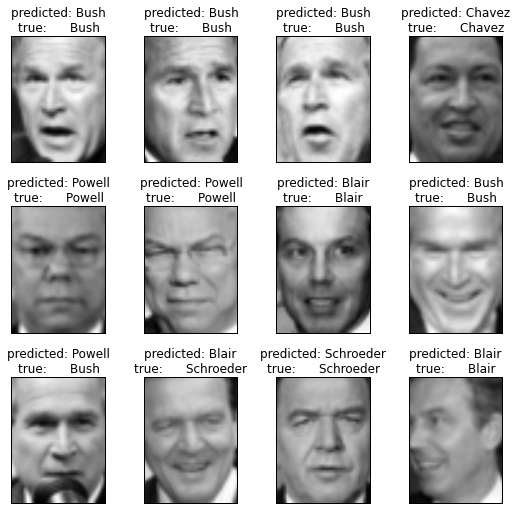

In [33]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

### Quantitative evaluation of the model quality on the test set

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.73      0.68        22
     Colin Powell       0.74      0.83      0.79        66
  Donald Rumsfeld       0.62      0.84      0.71        25
    George W Bush       0.96      0.79      0.87       123
Gerhard Schroeder       0.74      0.83      0.78        24
      Hugo Chavez       0.80      0.89      0.84        18
       Tony Blair       0.80      0.75      0.78        44

      avg / total       0.82      0.80      0.81       322



In [35]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[16  3  1  0  0  1  1]
 [ 3 55  3  2  1  1  1]
 [ 2  0 21  0  0  1  1]
 [ 3 12  4 97  2  1  4]
 [ 0  1  2  0 20  0  1]
 [ 0  1  0  1  0 16  0]
 [ 1  2  3  1  4  0 33]]
